In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import torch
import os
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

from cdvae.pl_data.dataset import CrystDataset
from cdvae.common.data_utils import get_scaler_from_data_list
from scripts.eval_utils import load_model

In [ ]:
path='/home/tsaidi/Research/cdvae_xrd/hydra/singlerun/2024-03-27/mp_20_sinc_filt_gauss_filt_nanomaterial_size_50'

model, data_loader, cfg = load_model(
    Path(path), load_data=True, batch_size=1)

In [ ]:
batch = next(iter(data_loader)).to(model.device)

# raw_sinc = batch.raw_sinc
xrd_presubsample = batch.xrd_presubsample
sinc_presubsample = batch.raw_sinc_presubsample
Qs = data_loader.dataset.Qs
Qs_shifted = data_loader.dataset.Qs_shifted
thetas = data_loader.dataset.xrd_thetas
sinc_filter = data_loader.dataset.sinc_filt

# print(xrd_presubsample.shape, sinc_presubsample.shape, Qs.shape, thetas.shape)
# print(Qs)
# print(thetas)

# # # plot XRDs
# print('plotting XRDs')
# plt.figure()
# plt.plot(thetas, xrd_presubsample.detach().cpu().numpy().squeeze())
# # plt.plot(thetas, sinc_presubsample.detach().cpu().numpy().squeeze())
# plt.savefig(f'xrd_theta.png')

# # # plot in Q space
# print('plotting Q space')
# plt.figure()
# plt.plot(Qs, xrd_presubsample.detach().cpu().numpy().squeeze())
# # plt.plot(Qs, sinc_presubsample.detach().cpu().numpy().squeeze())
# plt.savefig(f'xrd_Q.png')

In [ ]:
# plt.plot(Qs_shifted, sinc_filter)

In [ ]:
def plot_filter(filter, Qs):
    fig, ax = plt.subplots()
    dQ = (Qs[-1] - Qs[0])/filter.shape[0]
    # plot filter
    ax.plot(Qs, filter)
    ax.set_xlabel(r'Q $({A^{\circ}}^{-1})$')
    ax.set_ylabel('Filter value')
    ax.set_xticks(np.arange(-6, 6, 1))
    ax.set_xticklabels(ax.get_xticks(), rotation=70)  # Rotate x-axis labels by 70 degrees
    ax.set_yticks(np.arange(-0.3, 1.1, 0.1))  # Set horizontal gridlines every 0.1 from 0 to 1
    ax.grid(True)  # Show gridlines
    plt.tight_layout()

    # plot filter in spatial domain
    # inverse shift the signal and fourier transform to freq domain
    F = np.fft.ifft(np.fft.fftshift(filter))
    # shift the signal back in freq domain
    F_shifted = np.fft.ifftshift(F)
    # calculate frequency bins
    freq = np.fft.fftfreq(filter.shape[0], dQ)
    # shift the frequencies
    freq_shifted = np.fft.fftshift(freq)
    # scale and plot
    fig, ax = plt.subplots()
    ax.plot(freq_shifted, np.real(F_shifted))
    ax.set_xlabel(r'Spatial $(A^{\circ})$')
    ax.set_ylabel('Amplitude')

    ax.set_xticks(np.arange(-175, 175, 25))
    ax.set_xticklabels(ax.get_xticks(), rotation=70)  # Rotate x-axis labels by 70 degrees
    ax.set_yticks(np.arange(-0.01, 0.05, 0.01))  # Set horizontal gridlines every 0.1 from 0 to 1
    ax.grid(True)  # Show gridlines
    plt.tight_layout()



In [ ]:


plot_filter(sinc_filter, Qs_shifted)


-3.0057354589402966e-20


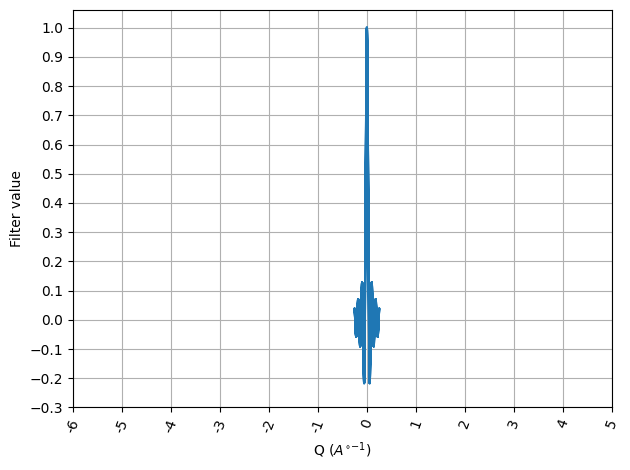

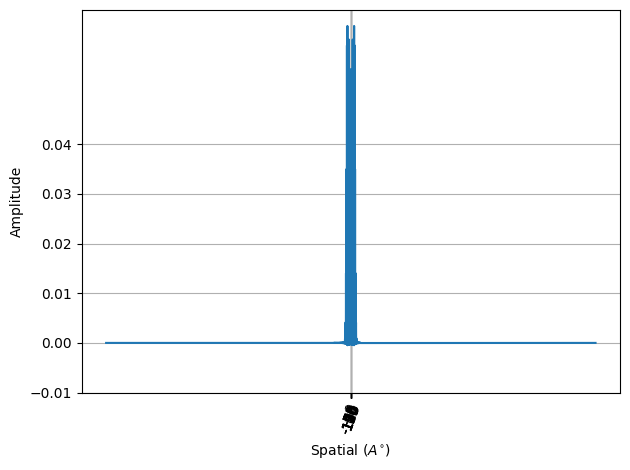

In [23]:
xrd_thetas = np.linspace(-np.pi, np.pi, 4096)
Qs = 4 * np.pi * np.sin(2 * xrd_thetas) / 50
Qs_shifted = 4 * np.pi * np.sin(2 * (xrd_thetas - np.pi)) / 50
sinc_filter = np.sinc(50/2 * Qs_shifted)

plot_filter(sinc_filter, Qs_shifted)
